In [1]:
import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import null_space
import time
from scipy.stats.distributions import chi2
import pickle
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv, splu
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftshift
import pygmt

from haversine import haversine, Unit
import gstools as gs

from pykrige.ok import OrdinaryKriging
import seaborn as sns

import matplotlib.image as mpimg

## 1. Estimate a linear rate from GNSS time series and test what model best describes the local site motion in time.

We start by loading MIDAS data, which will be used to verify our velocity vectors.

In [2]:
df = pd.read_csv('midas.IGS14_1.txt', sep=r"\s+", header=None)
data = np.array(df)

Now we downloaded data from all stations near the area of study. In order to select which stations we wanted to get data from, and what would be the time frame, we plotted the them all from 2000 to 2024 and visually inspected them.

That image can be found in `all_stations_2000_2024.png`. To see it in detail please refer to the file in the main folder. Otherwise, here's a miniature of it:

<center>
<img src="all_stations_2000_2024.png" alt="drawing" style="width:500px;"/>
</center>

In the end we selected the stations listed below, from 2009 to 2022. That plot is found in `selected_stations_2009_2022`, a miniature can be see below:

<center>
<img src="selected_stations_2009_2022.png" alt="drawing" style="width:500px;"/>
</center>

In [3]:
# plot from 2009 to 2022

list_of_chosen_stations = [
    "CALB", "CAMT", "CAOD", "CARK", "CMBB", "CMOD",
    "CROW", "CYTE", "DIAB", "FLNT", "LUTZ", "MHCB",
    "P140", "P171", "P172", "P174", "P175", "P180",
    "P210", "P211", "P212", "P213", "P214", "P215",
    "P216", "P217", "P226", "P227", "P228", "P229",
    "P230", "P231", "P232", "P233", "P234", "P235",
    "P241", "P242", "P243", "P244", "P247", "P248",
    "P249", "P250", "P252", "P253", "P254", "P255",
    "P256", "P257", "P258", "P265", "P266", "P267",
    "P268", "P271", "P274", "P275", "P276", "P285",
    "P286", "P287", "P288", "P289", "P290"
]

The code commented out below will go over the `*.tenv3` data of the selected stations and will get the station name, time, east and north velocities, their sigmas, build the `Q_yy_inverted` (sparse) matrices from them and append everything into a dictionary called `d`. Since this code takes a little while to run, we have pickled this dictionary into `d.pkl`, also available in the main folder. Therefore, there is no reason to run the below code anymore.

In [4]:
# keys = ["station", "Q_yy_east_inv", "Q_yy_north_inv", "Q_yy_up_inv", "time", "east", "north", "up"]

# d = {key: [] for key in keys}

# def get_data_we_want(df):
#     station = df.iloc[0, 0]
#     time = df.iloc[:, 2]
#     east = df.iloc[:, 8]
#     north = df.iloc[:, 10]    
#     up = df.iloc[:, 12]

#     sigma_east = df.iloc[:, 14]
#     sigma_north = df.iloc[:, 15]
#     sigma_up = df.iloc[:, 16]

#     Q_yy_east = np.diag(sigma_east*sigma_east)
#     Q_yy_north = np.diag(sigma_north*sigma_north)
#     Q_yy_up = np.diag(sigma_up*sigma_up)

#     Q_yy_east_sparse = csc_matrix(Q_yy_east)
#     Q_yy_north_sparse = csc_matrix(Q_yy_north)
#     Q_yy_up_sparse = csc_matrix(Q_yy_up)

#     Q_yy_east_inv_sparse = inv(Q_yy_east_sparse)
#     Q_yy_north_inv_sparse = inv(Q_yy_north_sparse)
#     Q_yy_up_inv_sparse = inv(Q_yy_up_sparse)

#     return station, Q_yy_east_inv_sparse, Q_yy_north_inv_sparse, Q_yy_up_inv_sparse, time, east, north, up

# dfs = []

# for file in list_of_chosen_stations:
#     file_path = os.path.join("DATA", f"{file}.tenv3")
#     df = pd.read_csv(file_path, sep=r"\s+", header=0)
#     filtered_df = df[(df.iloc[:, 2] > 2008) & (df.iloc[:, 2] < 2022)]
#     dfs.append(filtered_df)

# for i, df in enumerate(dfs):
#     print(f"Processing {i+1} out of {len(dfs)}.", end="\r")
#     station, Q_yy_east_inv_sparse, Q_yy_north_inv_sparse, Q_yy_up_inv_sparse, time, east, north, up = get_data_we_want(df)
#     d["station"].append(station)
#     d["Q_yy_east_inv"].append(Q_yy_east_inv_sparse)
#     d["Q_yy_north_inv"].append(Q_yy_north_inv_sparse)
#     d["Q_yy_up_inv"].append(Q_yy_up_inv_sparse)
#     d["time"].append(time)
#     d["east"].append(east)
#     d["north"].append(north)
#     d["up"].append(up)

# filename = "d.pkl"
# with open(filename, "wb") as f:
#     pickle.dump(d, f)

Below we specify all functions used throughout the assignment. Every function has a docstring explaining what they do.

In [5]:
def plot_images_side_by_side(image_path1, image_path2):
    """
    Plots two images side by side.
    """
    from matplotlib import pyplot as plt
    import matplotlib.image as mpimg
    
    img1 = mpimg.imread(image_path1)
    img2 = mpimg.imread(image_path2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].axis('off')


    plt.tight_layout()
    plt.savefig("velocities_comparison.png")
       
    plt.show()

In [6]:
def parse_faults(file_path):
    """
    This function reads the file containing the San Andreas fault lat/lon coordinates and returns a dictionary of dataframes.
    """
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    faults = {}
    current_fault = None
    fault_index = 1
    
    for line in lines:
        line = line.strip()
        if line.startswith('#'): 
            if current_fault is not None:
                faults[f'df_fault_{fault_index}'] = pd.DataFrame(current_fault, columns=['longitude', 'latitude'])
                fault_index += 1
            current_fault = []  
        elif line: 
            lon, lat = map(float, line.split())
            current_fault.append((lon, lat))
    
    if current_fault is not None:
        faults[f'df_fault_{fault_index}'] = pd.DataFrame(current_fault, columns=['longitude', 'latitude'])
    
    return faults

In [7]:
def A0_matrix(station_idx, d):
    '''
    Computes the A0 matrix, which will be used as the null hypothesis in our GLR testing.
    It only computes the intercept and slope, as this is the simple model.
    '''
    A = np.ones((len(d['time'][station_idx]), 2))
    A[:, 1] = np.array(d['time'][station_idx])
    return A

In [8]:
def A1_matrix(t, peak_freqs):
    '''
    Computes the A1 matrix, which is the model we are testing against the null hypothesis.
    This model is a simple harmonic model with two frequencies.
    The frequencies are chosen as the two peak frequencies from the FFT of the data.
    '''
    if len(peak_freqs) > 2:
        raise ValueError("indices should be of length 2")
    
    A = np.ones((len(t), 6))
    A[:, 1] = np.array(t)
    A[:, 2] = np.sin(2*np.pi*t*peak_freqs[0])
    A[:, 3] = np.cos(2*np.pi*t*peak_freqs[0])
    A[:, 4] = np.sin(2*np.pi*t*peak_freqs[1])
    A[:, 5] = np.cos(2*np.pi*t*peak_freqs[1])

    return A

In [9]:
def BLUE(A, y, Q_yy_inv):
    '''
    This function computes the Best Linear Unbiased Estimator (BLUE).
    '''

    Q_x_hat = np.linalg.inv(A.T @ Q_yy_inv @ A)
    x_hat = np.linalg.solve(A.T @ Q_yy_inv @ A, A.T @ Q_yy_inv @ y)

    y_hat = A @ x_hat
    e_hat = y - y_hat

    return x_hat, Q_x_hat, y_hat, e_hat

In [10]:
def detrend_function(interpolated_values, regular_time_grid):
    '''
    This function detrends the data by fitting a linear model to it.
    '''
    slope, intercept = np.polyfit(regular_time_grid, interpolated_values, 1)
    trend = slope * regular_time_grid + intercept
    detrended_values = interpolated_values - trend
    return detrended_values

def dft_function(detrended_values, dt):
    '''
    This function computes the Discrete Fourier Transform (DFT) of the detrended values.
    '''
    dft = dt*fftshift(np.abs(fft(detrended_values)))
    N = detrended_values.size
    k = np.arange(0, N/2)

    freq = k/(N*dt)
    half_dft = dft[len(dft)//2:]

    return freq, half_dft


In [11]:
def GLR_function(e0, ea, Q_yy_inv, q=4, alpha=0.05):
    '''
    This function computes the Generalized Likelihood Ratio (GLR) test.
    '''
    Q_yy_inv = Q_yy_inv.toarray()
    T_q = (e0.T @ Q_yy_inv @ e0) - (ea.T @ Q_yy_inv @ ea)
    c2 = chi2.ppf(1 - alpha, df=q)

    if T_q < c2:
        return True
    
    return False


In [12]:
def create_vector(df):
    """
    This function computes direction and magnitude of velocity vectors for a dataframe.
    """
    v_north = np.array(df['north'].astype(float))
    v_east = np.array(df['east'].astype(float))
    direction = np.rad2deg(np.arctan2(v_north, v_east))
    magnitude = np.sqrt(v_east**2 + v_north**2)
    return direction, magnitude

def create_vector_midas(df):
    """
    Similar to the above but for the MIDAS dataset.
    """
    v_north = df.iloc[:, 9].astype(float)
    v_east = df.iloc[:, 8].astype(float)
    direction = np.rad2deg(np.arctan2(v_north, v_east))
    magnitude = np.sqrt(v_east**2 + v_north**2)
    return direction, magnitude

In [13]:
def transform_longitude(lon):
    """
    Transform longitude from 0-360 to -180 to 180 degrees.
    """
    return (lon - 360) * (lon > 180) + lon * (lon <= 180)


def transform_longitude_180_to_360(lon):
    """
    Transform longitude from -180-180 to 0-360 degrees.
    """
    return lon % 360 if lon < 0 else lon


In [14]:
df_accepted = pd.DataFrame(columns=["east", "north", "up"], index=list_of_chosen_stations)
df_velocities = df_accepted.copy(deep=True)

Here we compute everything using the functions above. We compute `A0` and `A1`, and create both models. 

For `A1` we get the two peak frequencies from each station data.  

We then perform the GLR test with both models and whichever gets accepted, is used. For the 65 stations, the null hypthoesis (model `A0`) is rejected in all of them.

We also create plots of the detrended data and of the DFT of them. We do all of this for `east`, `north` and `up`. However, we do not use `up` anywhere in this assignment.

The plots can be found in the main folder as `detrended.png` and `dft.png`. If you wish to create the plots, change the `plot = False` below into `True`.

(On my laptop, it takes around 20 seconds to compute everything without ploting)

In [15]:
plot = False

d_file ="d.pkl"
with open(d_file, "rb") as f:
    d = pickle.load(f)

variables = ["east", "north", "up"]
dt = 1/12
regular_time_grid = np.arange(2008, 2022, dt)


if plot:
    fig1, axes1 = plt.subplots(nrows=len(d['station']), ncols=3, figsize=(30, 90)) 
    fig2, axes2 = plt.subplots(nrows=len(d['station']), ncols=3, figsize=(30, 90))  
    fig3, axes3 = plt.subplots(nrows=len(d['station']), ncols=3, figsize=(30, 90))  

    ax_flat_1 = axes1.flatten()
    ax_flat_2 = axes2.flatten()
    ax_flat_3 = axes3.flatten()

    i = 0

for idx in range(len(d['station'])):   
    print(f"Processing {idx+1} out of {len(d['station'])}.", end="\r")

    A = A0_matrix(idx, d)
    t = d['time'][idx]

    accepted_list = []
    velocities_list = []

    for variable in variables:
        y = d[variable][idx] * 1e3 # mm
        Q_yy_inv = d[f'Q_yy_{variable}_inv'][idx] * 1e-3 # mm

        x_hat_linear, Q_x_hat_linear, y_hat_linear, e_hat_linear = BLUE(A, y, Q_yy_inv)

        interpolated_function = interp1d(t, y, kind='linear', fill_value='extrapolate')
        interpolated_values = interpolated_function(regular_time_grid)

        detrended_values = detrend_function(interpolated_values, regular_time_grid)

        freq, half_dft = dft_function(detrended_values, dt)

        indices = np.argsort(half_dft)[-2:][::-1]

        peak_freqs = freq[indices]

        A1 = A1_matrix(t, peak_freqs)

        x_hat_periodic, Q_x_hat_periodic, y_hat_periodic, e_hat_periodic = BLUE(A1, y, Q_yy_inv)      

        accepted = GLR_function(e_hat_linear, e_hat_periodic, Q_yy_inv)

        if accepted:
            slope = x_hat_linear[1] 
        
        else:
            slope = x_hat_periodic[1]

        velocities_list.append(slope)
        accepted_list.append(accepted)

        if plot:
            ax = ax_flat_1[i]
            ax.plot(regular_time_grid, detrended_values)
            ax.set_title(f"Detrended {variable} for {d['station'][idx]}.")
            ax.set_xlabel("Time")
            ax.set_ylabel("Displacement (mm)")
            ax.grid(True)

            ax = ax_flat_2[i]
            
            ax.stem(half_dft)
            ax.set_title(f"DFT of detrended {variable} for {d['station'][idx]}.")
            ax.set_xlabel("Frequency (cycle/year)")
            ax.set_ylabel("Magnitude")
            

            ax = ax_flat_3[i]
            ax.plot(t, y, label="Original", ls='--')
            ax.plot(t, y_hat_periodic, label="Periodic")
            ax.set_title(f"Original {variable} for {d['station'][idx]}.")
            ax.set_xlabel("Time")
            ax.set_ylabel("Displacement (mm)")
            ax.grid(True)
            ax.legend()

            i += 1
            
    df_velocities.loc[d['station'][idx]] = velocities_list
    df_accepted.loc[d['station'][idx]] = accepted_list

if plot:
    fig1.tight_layout()
    fig1.savefig("detrended.png")
    plt.close()
    
    fig2.tight_layout()
    fig2.savefig("dft.png")
    plt.close()

    fig3.tight_layout()
    fig3.savefig("original_vs_periodic_model.png")
    plt.close()

Here we check that the null hypothesis was rejected for all data.

In [16]:
(df_accepted == True).sum(), (df_accepted == False).sum()

(east     0
 north    0
 up       0
 dtype: int64,
 east     65
 north    65
 up       65
 dtype: int64)

Here we transform the `east` and `north` velocities into `direction` and `magnitude` so that we can visualize our resuts using `PyGMT`.

In [17]:
df_velocities[["direction", "magnitude"]] = np.transpose(create_vector(df_velocities))

And we create a `filtered_df` which are the `MIDAS5` data of our selected stations and compute the `direction` and `magnitude` for it too.

In [18]:
filtered_df = df[df.iloc[:, 0].isin(list_of_chosen_stations)]
direction, magnitude = create_vector_midas(filtered_df)
filtered_df["direction"] = direction
filtered_df["magnitude"] = magnitude

C:\Users\gui-win10\AppData\Local\Temp\ipykernel_18720\4046132156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["direction"] = direction
C:\Users\gui-win10\AppData\Local\Temp\ipykernel_18720\4046132156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["magnitude"] = magnitude


The code below generated three images: `velocities_gnss.png`, `velocities_midas5.png` and `velocities_comparison.png`. All pictures can be found in the main folder, however below we show only the `velocities_comparison.png` which compares the velocity vectors that we computed from the GNSS data vs. the velocities vector directly taken from the `MIDAS5` data. It can be seen that they are very similar.

In [19]:
longitude_vector = filtered_df.iloc[:, 25].values
latitude_vector = filtered_df.iloc[:, 24].values
direction_vector = df_velocities["direction"].values
magnitude_vector = df_velocities["magnitude"].values // 10

vector = [longitude_vector, latitude_vector, direction_vector, magnitude_vector]

In [20]:
min_lat, max_lat, min_lon, max_lon = 36, 38, -122, -120

longitude_vector = filtered_df.iloc[:, 25].values
latitude_vector = filtered_df.iloc[:, 24].values
direction_vector = df_velocities["direction"].values
magnitude_vector = df_velocities["magnitude"].values // 10

vector = [longitude_vector, latitude_vector, direction_vector, magnitude_vector]

region = [
    min_lon-6, max_lon+6, min_lat-6, max_lat+6
]

fig = pygmt.Figure()
fig.basemap(region=region, 
            projection="M15c", 
            frame=["afg", 
                   "+tComputed velocities from GNSS data"])

fig.coast(shorelines="1/0.5p,black")

fig.plot(
    x=longitude_vector,
    y=latitude_vector,
    style="v0.6c+e",  
    direction=[direction_vector, magnitude_vector], 
    pen="2p",
    fill="red3",
    region=region,
    projection="M6i"
)

scale_lon = min_lon - 5 
scale_lat = max_lat - 7 
scale_length = 2 
scale_direction = 0 

fig.plot(
    x=[scale_lon],
    y=[scale_lat],
    style="v0.6c+e",
    direction=[[scale_direction], [scale_length]],
    pen="2p",
    fill="blue",
    label="20 mm/year"
)

fig.text(
    x=scale_lon + 0.9, 
    y=scale_lat - 0.3,
    text="20 mm/year",
    font="12p,Helvetica-Bold,black"
)
fig.savefig("velocities_gnss.png")

min_lat, max_lat, min_lon, max_lon = 36, 38, -122, -120

longitude_vector = filtered_df.iloc[:, 25].values
latitude_vector = filtered_df.iloc[:, 24].values
direction_vector = filtered_df["direction"].values
magnitude_vector = filtered_df["magnitude"].values * 100

vector = [longitude_vector, latitude_vector, direction_vector, magnitude_vector]

region = [
    min_lon-6, max_lon+6, min_lat-6, max_lat+6
]

fig = pygmt.Figure()
fig.basemap(region=region, 
            projection="M15c", 
            frame=["afg", 
                   "+tObserved velocities from MIDAS5 data"])

fig.coast(shorelines="1/0.5p,black")

fig.plot(
    x=longitude_vector,
    y=latitude_vector,
    style="v0.6c+e",  
    direction=[direction_vector, magnitude_vector],  
    pen="2p",
    fill="red3",
    region=region,
    projection="M6i"
)

scale_lon = min_lon - 5  
scale_lat = max_lat - 7  
scale_length = 2 
scale_direction = 0 

fig.plot(
    x=[scale_lon],
    y=[scale_lat],
    style="v0.6c+e",
    direction=[[scale_direction], [scale_length]],
    pen="2p",
    fill="blue",
    label="20 mm/year"
)

fig.text(
    x=scale_lon + 0.9,  
    y=scale_lat - 0.3,
    text="20 mm/year",
    font="12p,Helvetica-Bold,black"
)
fig.savefig("velocities_midas5.png")

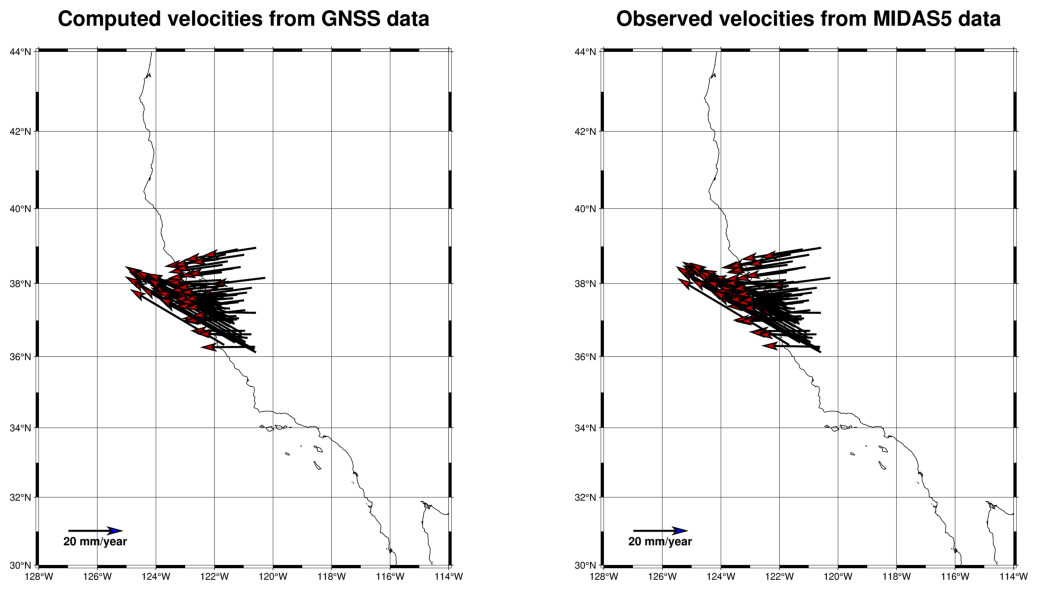

In [21]:
plot_images_side_by_side("velocities_gnss.png", "velocities_midas5.png")

We see from the images above that our computed velocity vectors agree with the ones from the MIDAS5 dataset.

In [22]:
df_velocities["latitude"] = filtered_df.iloc[:, 24].values
df_velocities["longitude"] = filtered_df.iloc[:, 25].values

## 2. Estimate the linear horizontal velocity field of the study area

Here we load the grid coordinates file, which we will then filter out an area close to our study area. The plot of the postiion of the GNSS stations and the grid we created can seen below.

In [23]:
grid_coordinates = pd.read_csv("topography/grid-512.xy", delimiter=" ",
                               header=None, names=['longitude', 'latitude'])

In [24]:
lat_min = 33
lat_max = 42
lon_min = -125
lon_max = -117

In [25]:
grid_coordinates["longitude"] = transform_longitude(grid_coordinates["longitude"])

In [26]:
coordinates_of_interest = grid_coordinates[
    (grid_coordinates.latitude >= lat_min) & (grid_coordinates.latitude <= lat_max) &
    (grid_coordinates.longitude >= lon_min) & (grid_coordinates.longitude <= lon_max)
]

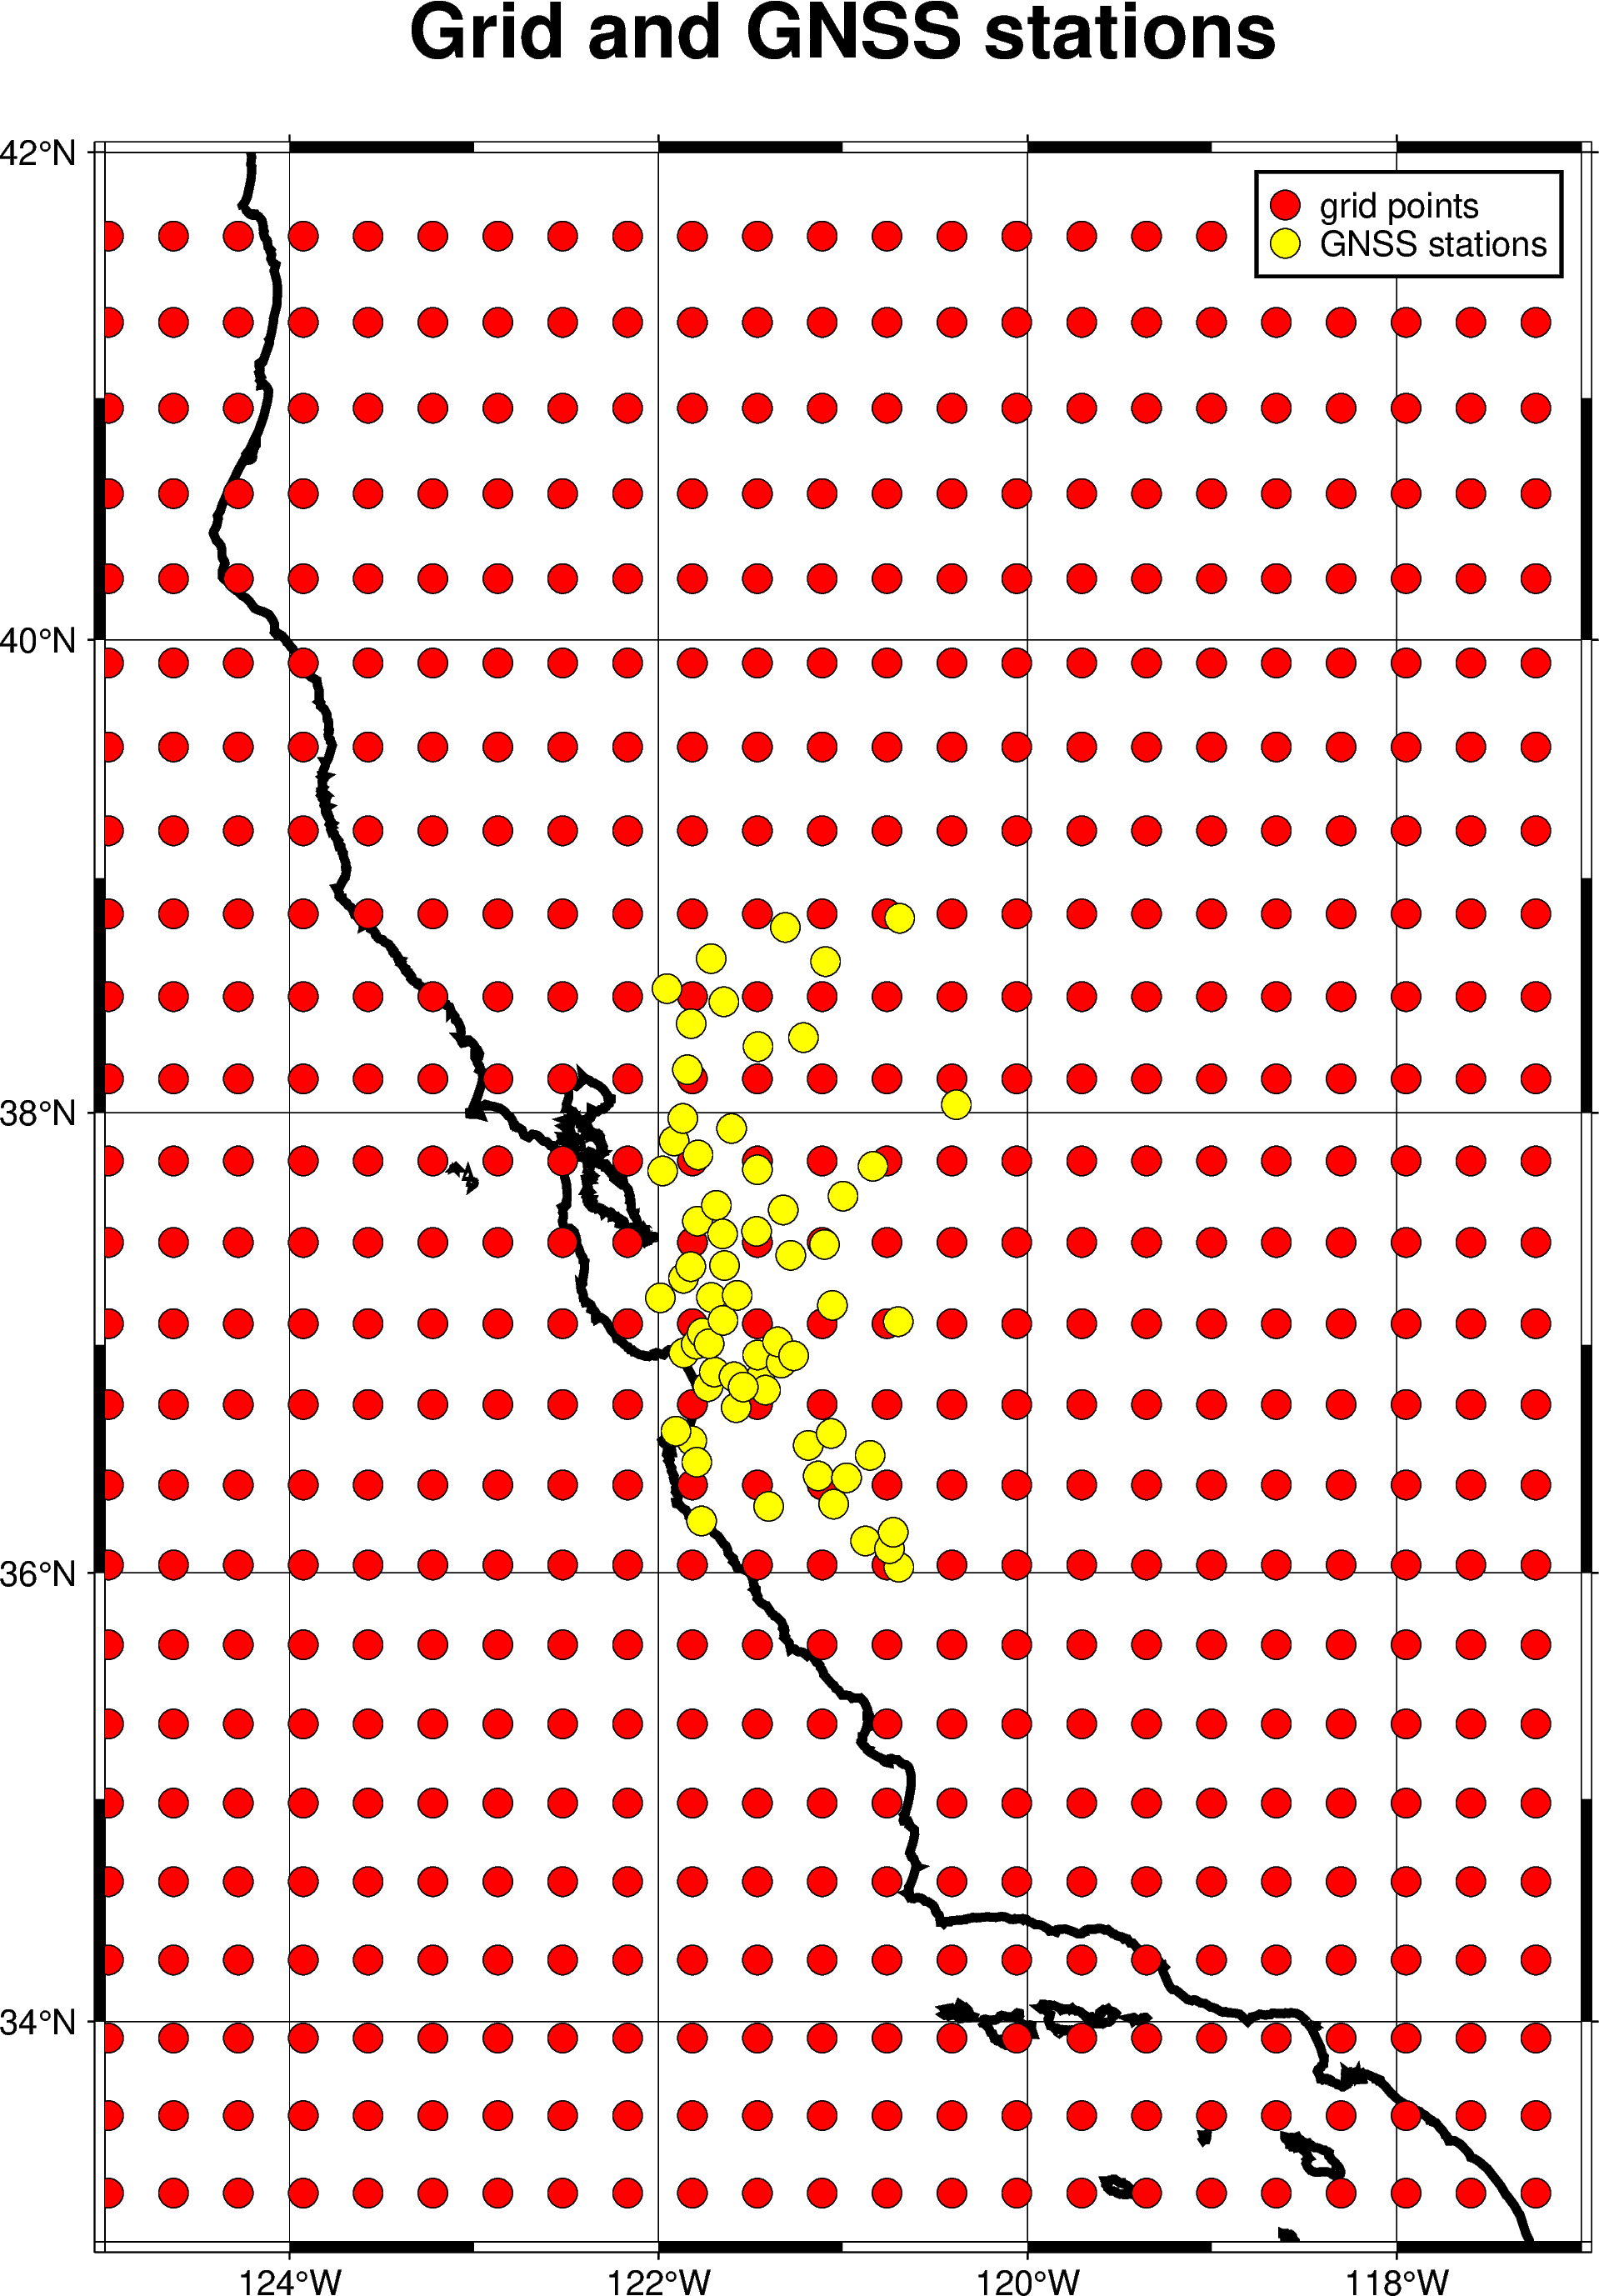

In [27]:
region = [
    lon_min,
    lon_max,
    lat_min,
    lat_max
]

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=["afg", "+tGrid and GNSS stations"])
fig.coast(shorelines="1/2.5p,black")
fig.plot(coordinates_of_interest, style="c0.3c", fill="red", pen="black", label="grid points")
fig.plot(x=df_velocities["longitude"], y=df_velocities["latitude"], style="c0.3c", fill="yellow", pen="black", label="GNSS stations")
fig.legend()
fig.show()

Now, in order to create an East and North velocity field maps we will perform Ordinary Kriging using the values that we know (GNSS stations) to estimate the values in the grid. First, we compute the variogram for both a spherical model and exponential model to see which one fits best:

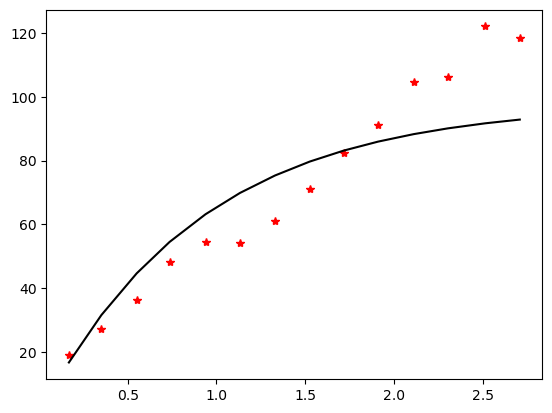

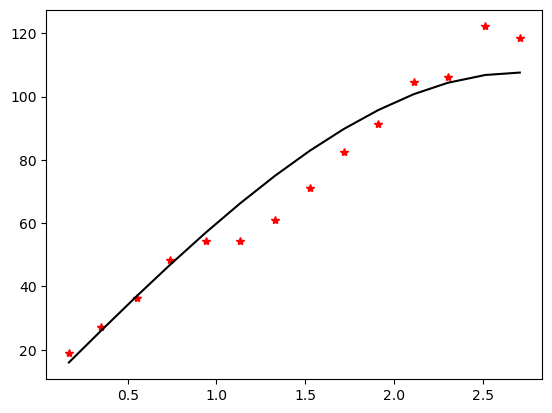

In [28]:
# for east component

OK_exponential_east= OrdinaryKriging(
    df_velocities['longitude'], df_velocities['latitude'], df_velocities['east'],
    variogram_model = 'exponential', enable_plotting=True, coordinates_type='geographic', nlags=14
)

OK_spherical_east = OrdinaryKriging(
    df_velocities['longitude'], df_velocities['latitude'], df_velocities['east'],
    variogram_model = 'spherical', enable_plotting=True, coordinates_type='geographic', nlags=14
)


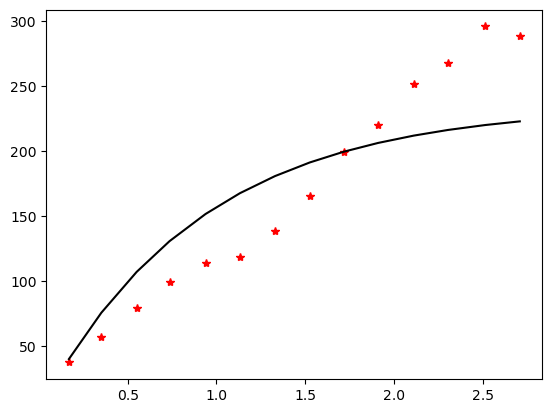

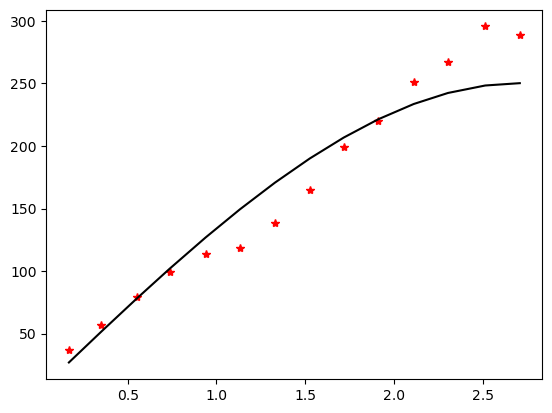

In [29]:
# for north component

OK_exponential_north= OrdinaryKriging(
    df_velocities['longitude'], df_velocities['latitude'], df_velocities['north'],
    variogram_model = 'exponential', enable_plotting=True, coordinates_type='geographic', nlags=14
)

OK_spherical_north = OrdinaryKriging(
    df_velocities['longitude'], df_velocities['latitude'], df_velocities['north'],
    variogram_model = 'spherical', enable_plotting=True, coordinates_type='geographic', nlags=14
)


Sorry for the lack of labels in the plots above but we didn't figure out how to make them better... Nonetheless, we can see that the spherical model fits better for both the `earth` and `north` velocities. 

Now we compute the east and north velocities (and their variances) using Ordinary Kriging

In [30]:
dx = abs(grid_coordinates["longitude"][0] - grid_coordinates["longitude"][1])

In [31]:
longitude = coordinates_of_interest['longitude'].values
latitude = coordinates_of_interest['latitude'].values

longitude_array = np.arange(longitude.min(), longitude.max()+dx, dx)
latitude_array = np.arange(latitude.min(), latitude.max()+dx, dx)

east_estimate, east_var = OK_spherical_east.execute("grid", longitude_array, latitude_array)
north_estimate, north_var = OK_spherical_north.execute("grid", longitude_array, latitude_array)


In [34]:
east_estimate = np.flipud(east_estimate.data)
east_df = coordinates_of_interest.copy(deep=True)
east_df["east"] = east_estimate.flatten()

In [35]:
north_estimate = np.flipud(north_estimate.data)
north_df = coordinates_of_interest.copy(deep=True)
north_df["north"] = north_estimate.flatten()

In [36]:
fault_dfs = parse_faults("fault_information.txt")

In [37]:
fig = pygmt.Figure()

longitude_vector = filtered_df.iloc[:, 25].values
latitude_vector = filtered_df.iloc[:, 24].values
direction_vector = df_velocities["direction"].values
magnitude_vector = df_velocities["magnitude"].values // 10

vector = [longitude_vector, latitude_vector, direction_vector, magnitude_vector]

east_grid = pygmt.xyz2grd(east_df,
                        region = [
                            coordinates_of_interest.longitude.min(), 
                            coordinates_of_interest.longitude.max(), 
                            coordinates_of_interest.latitude.min(), 
                            coordinates_of_interest.latitude.max()
                            ],
                        spacing = [dx,dx] )

pygmt.makecpt(cmap="viridis", series=[-60, -10])

projection = "M6i"

fig.grdimage(grid=east_grid, projection=projection, region=region, 
                frame=["afg", f"+tEast Velocity Field"], cmap=True)

fig.coast(shorelines="1/2.5p,black", region=region, projection=projection)

for i, k in enumerate(fault_dfs.keys()):
    lon = fault_dfs[k]["longitude"]
    lat = fault_dfs[k]["latitude"]

    if i == 0:
        fig.plot(x=lon, y=lat, pen="1.5p,red", label="San Andreas Fault")

    fig.plot(x=lon, y=lat, pen="1.5p,red")

fig.plot(
    x=longitude_vector,
    y=latitude_vector,
    style="v0.6c+e",  
    direction=[direction_vector, magnitude_vector],  
    pen="2p",
    fill="red3",
    region=region,
    projection="M6i"
)

fig.colorbar(frame=["x+l[mm/year]"])
fig.legend()

fig.savefig("east_velocity_field.png")

In [38]:
fig = pygmt.Figure()

longitude_vector = filtered_df.iloc[:, 25].values
latitude_vector = filtered_df.iloc[:, 24].values
direction_vector = df_velocities["direction"].values
magnitude_vector = df_velocities["magnitude"].values // 10

vector = [longitude_vector, latitude_vector, direction_vector, magnitude_vector]

north_grid = pygmt.xyz2grd(north_df,
                        region = [
                            coordinates_of_interest.longitude.min(), 
                            coordinates_of_interest.longitude.max(), 
                            coordinates_of_interest.latitude.min(), 
                            coordinates_of_interest.latitude.max()
                            ],
                        spacing = [dx,dx] )

pygmt.makecpt(cmap="viridis", series=[-10, 30])

projection = "M6i"

fig.grdimage(grid=north_grid, projection=projection, region=region, 
                frame=["afg", f"+tNorth Velocity Field"], cmap=True)

fig.coast(shorelines="1/2.5p,black", region=region, projection=projection)

for i, k in enumerate(fault_dfs.keys()):
    lon = fault_dfs[k]["longitude"]
    lat = fault_dfs[k]["latitude"]

    if i == 0:
        fig.plot(x=lon, y=lat, pen="1.5p,red", label="San Andreas Fault")

    fig.plot(x=lon, y=lat, pen="1.5p,red")

fig.plot(
    x=longitude_vector,
    y=latitude_vector,
    style="v0.6c+e",  
    direction=[direction_vector, magnitude_vector], 
    pen="2p",
    fill="red3",
    region=region,
    projection="M6i",
    label="Velocity vector"
)

fig.colorbar(frame=["x+l[mm/year]"])
fig.legend()

fig.savefig("north_velocity_field.png")

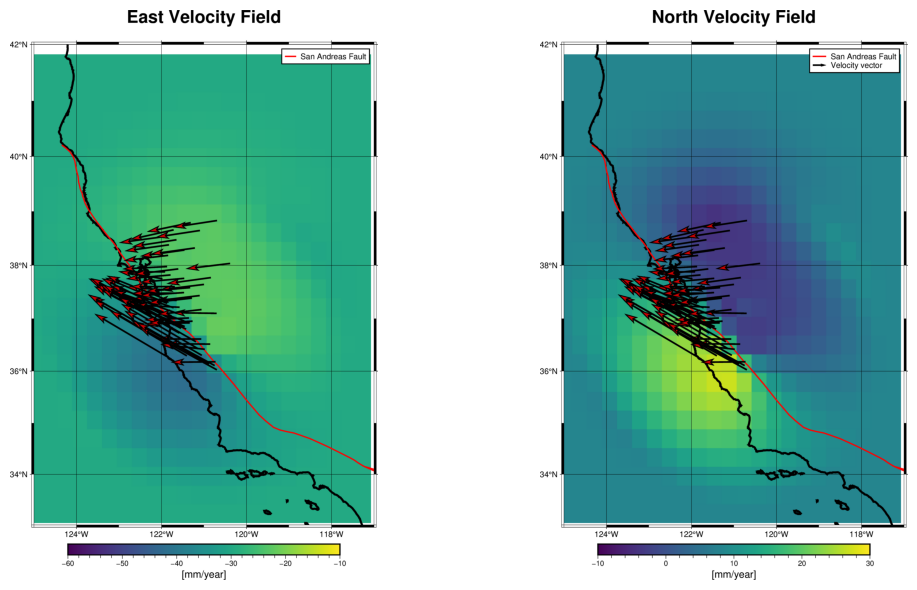

In [39]:
plot_images_side_by_side("east_velocity_field.png", "north_velocity_field.png")

## 3. Calculate strain rates for the area and compare this to independent geological or seismological data.

In [40]:
longitude_I_want0 = coordinates_of_interest.iloc[0].longitude
longitude_I_want1 = coordinates_of_interest.iloc[1].longitude

latitude_I_want0 = coordinates_of_interest.iloc[0].latitude
latitude_I_want1 = coordinates_of_interest.iloc[1].latitude

In [41]:
haversine((latitude_I_want0, longitude_I_want0), (latitude_I_want1, longitude_I_want1), unit=Unit.METERS) * 10**3

29205651.882450562

In [70]:
v_e_d_e = np.gradient(east_estimate, axis=1)  
v_e_d_n = np.gradient(east_estimate, axis=0)  
v_n_d_e = np.gradient(north_estimate, axis=1)  
v_n_d_n = np.gradient(north_estimate, axis=0)  

D = np.zeros((east_estimate.shape[0], north_estimate.shape[1], 2, 2))

for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        L = np.array([[v_e_d_e[i, j], v_e_d_n[i, j]], [v_n_d_e[i, j], v_n_d_n[i, j]]])
        L_T = L.transpose()
        D[i, j] = 0.5 * (L + L_T)

D[0,0,1,1]

0.0

In [71]:
J = np.zeros_like(v_e_d_e)

for i in range(J[:,0].size):
    for j in range(J[0,:].size):
        J[i,j]= np.sqrt(D[i,j,0,0]* D[i,j,0,0]+D[i,j,1,1]*D[i,j,1,1])

In [72]:
J = J* 10

In [73]:
J.min(), J.max()

(0.0, 143.9119686112425)

In [77]:
J_df = 

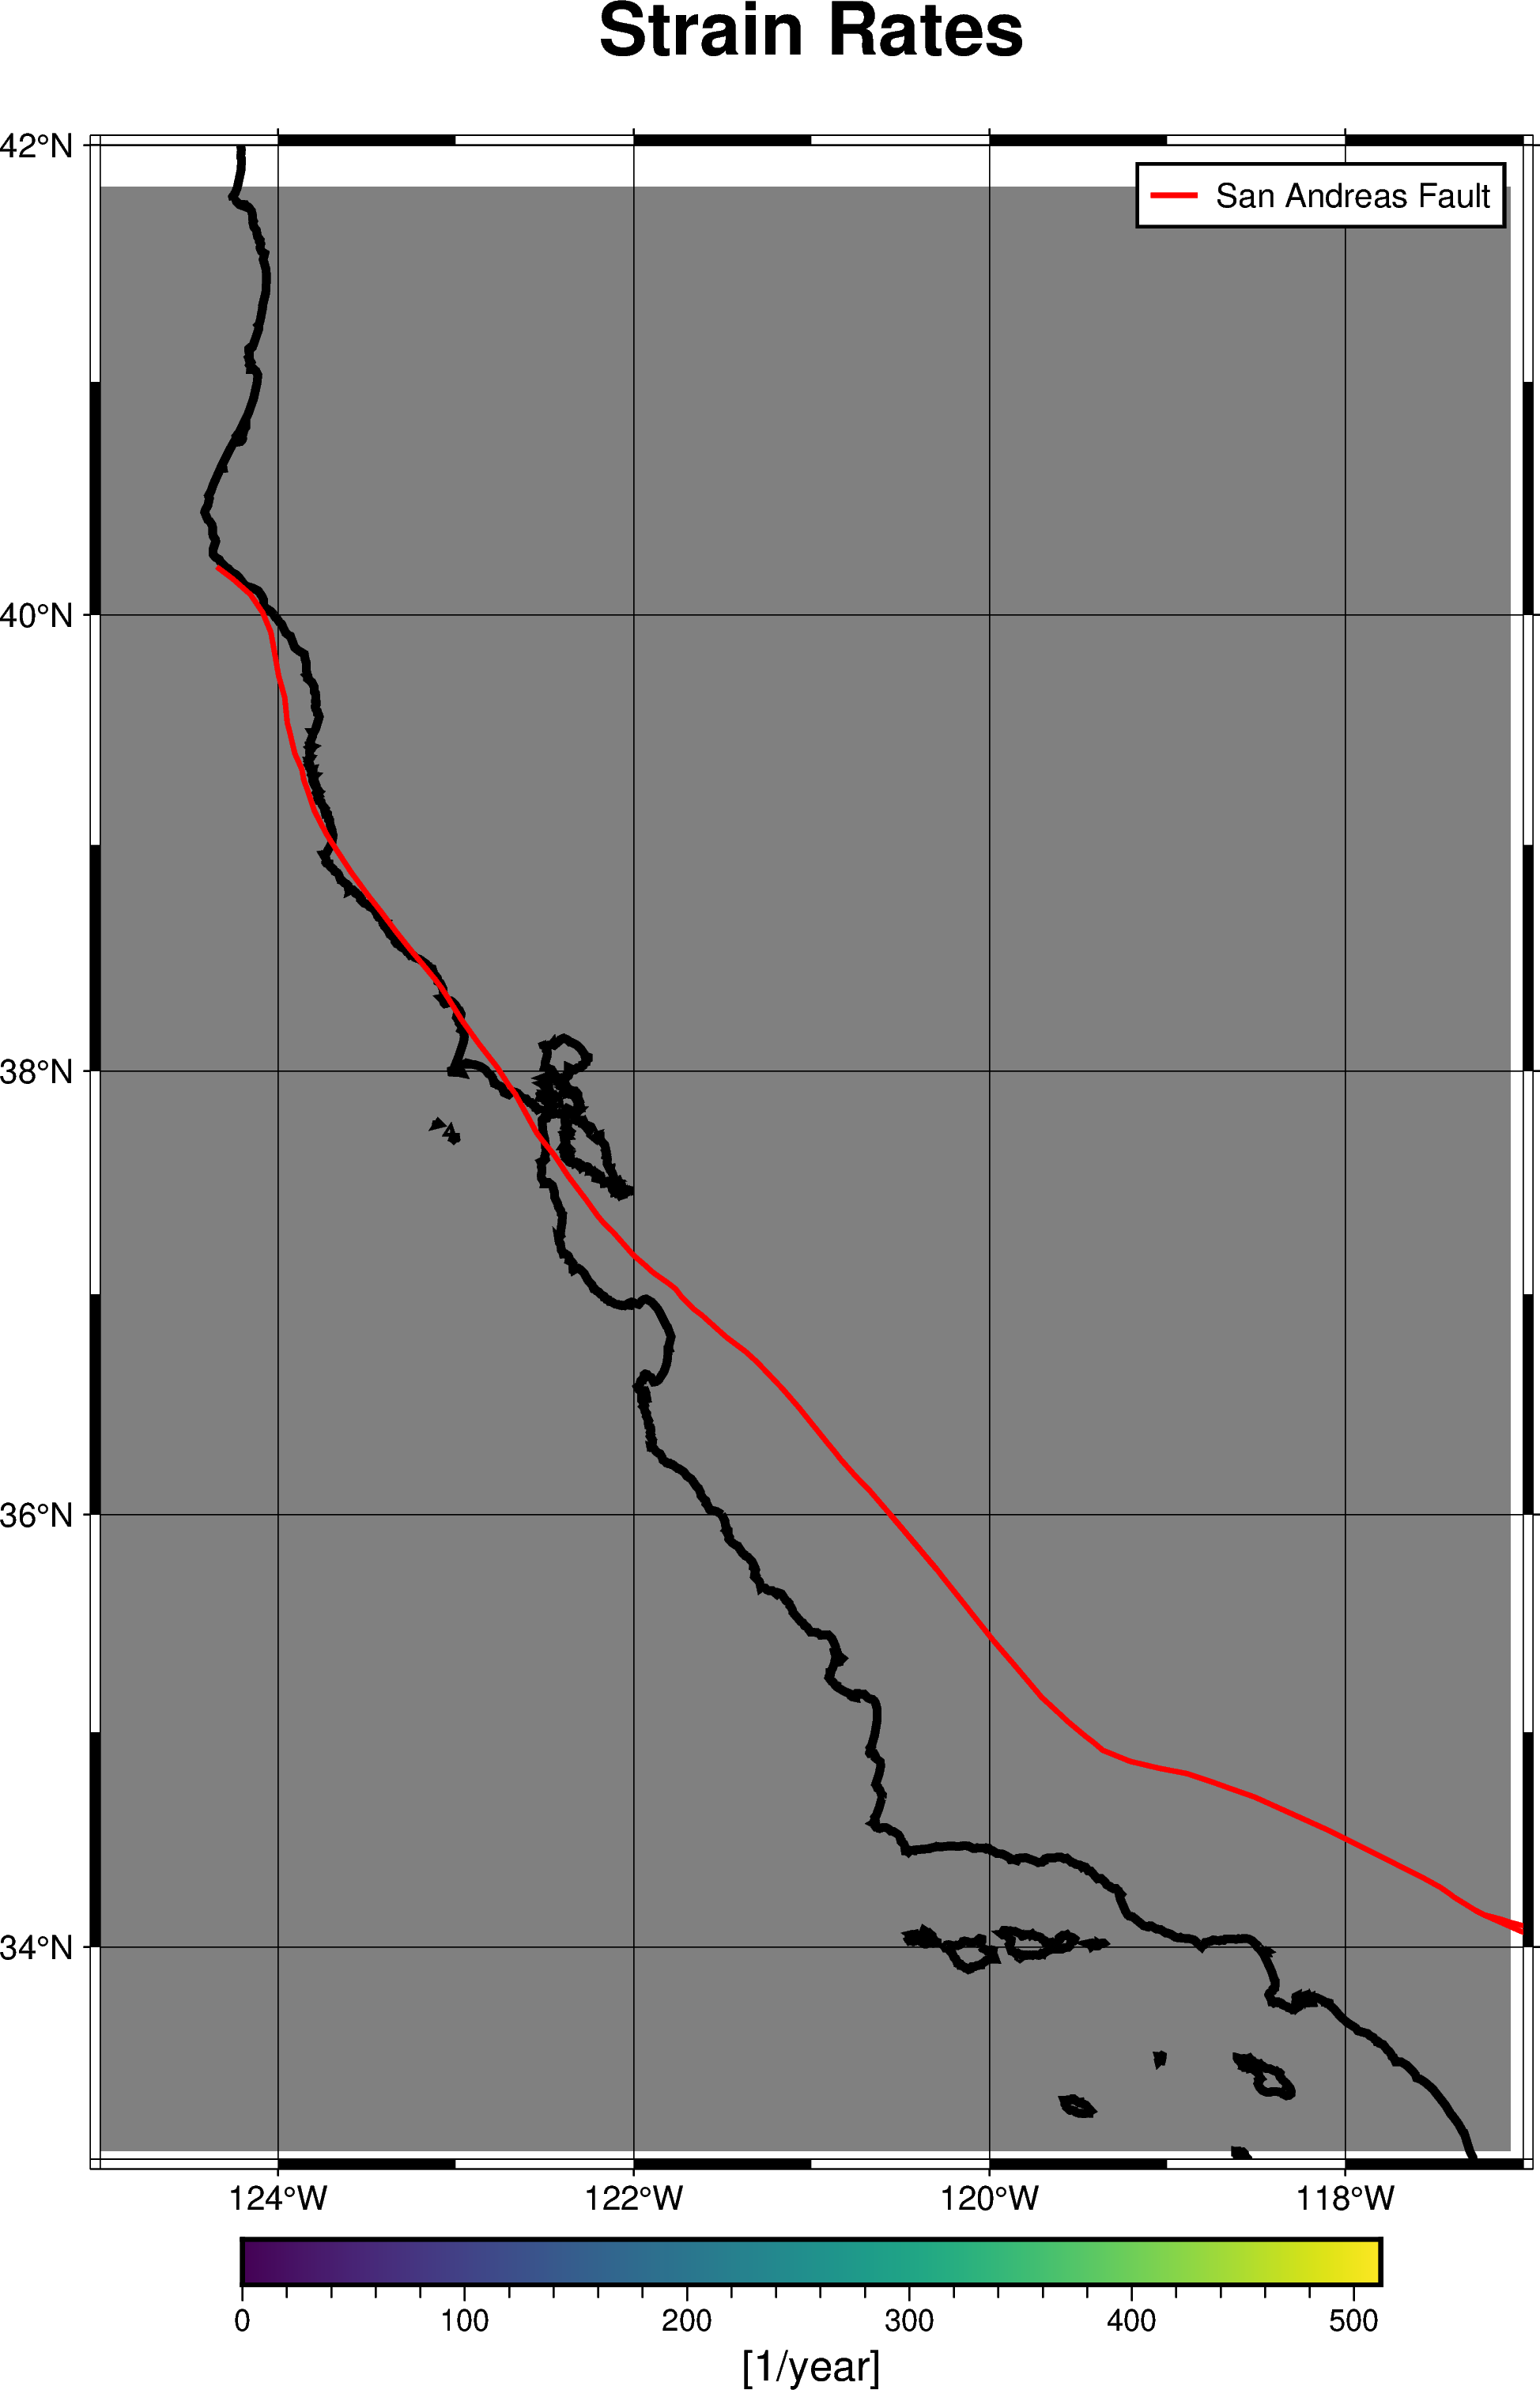

In [74]:
fig = pygmt.Figure()

J_grid = pygmt.xyz2grd(J,
                        region = [
                            coordinates_of_interest.longitude.min(), 
                            coordinates_of_interest.longitude.max(), 
                            coordinates_of_interest.latitude.min(), 
                            coordinates_of_interest.latitude.max()
                            ],
                        spacing = [dx,dx] )

pygmt.makecpt(cmap="viridis", series=[0, 512])

projection = "M6i"

fig.grdimage(grid=J_grid, projection=projection, region=region, 
                frame=["afg", f"+tStrain Rates"], cmap=True)

fig.coast(shorelines="1/2.5p,black", region=region, projection=projection)

for i, k in enumerate(fault_dfs.keys()):
    lon = fault_dfs[k]["longitude"]
    lat = fault_dfs[k]["latitude"]

    if i == 0:
        fig.plot(x=lon, y=lat, pen="1.5p,red", label="San Andreas Fault")

    fig.plot(x=lon, y=lat, pen="1.5p,red")


fig.colorbar(frame=["x+l[1/year]"])
fig.legend()
fig.show()
# fig.savefig("strain_rates.png")